In [1]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, inspect, func, desc

# data
import pandas as pd
import numpy as np

# viz
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os

In [2]:
SQL_USERNAME = "postgres"
SQL_PASSWORD = "postgres" # change this
SQL_IP = "localhost"
PORT = 5432
DATABASE = "crowdfunding_db" # change this


In [3]:
connection_string = f"postgresql+psycopg2://{SQL_USERNAME}:{SQL_PASSWORD}@{SQL_IP}:{PORT}/{DATABASE}"
engine = create_engine(connection_string)

In [4]:
# INSPECT

# Create the inspector and connect it to the engine
inspector_gadget = inspect(engine)

# Collect the names of tables within the database
tables = inspector_gadget.get_table_names()

# print metadata for each table
for table in tables:
    print(table)
    print("-----------")
    
    # get columns
    columns = inspector_gadget.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])

    print()

contacts
-----------
contact_id INTEGER
first_name VARCHAR(50)
last_name VARCHAR(50)
email VARCHAR(50)

campaign
-----------
cf_id INTEGER
contact_id INTEGER
company_name VARCHAR(50)
description VARCHAR(100)
goal DOUBLE PRECISION
pledged DOUBLE PRECISION
outcome VARCHAR(10)
backers_count INTEGER
country VARCHAR(2)
currency VARCHAR(3)
launch_date TIMESTAMP
end_date TIMESTAMP
category_id CHAR(4)
subcategory_id VARCHAR(8)

category
-----------
category_id CHAR(4)
category VARCHAR(30)

subcategory
-----------
subcategory_id CHAR(8)
subcategory VARCHAR(30)



In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

# Print all of the classes mapped to the Base
print(list(Base.classes))

[<class 'sqlalchemy.ext.automap.category'>, <class 'sqlalchemy.ext.automap.contacts'>, <class 'sqlalchemy.ext.automap.campaign'>, <class 'sqlalchemy.ext.automap.subcategory'>]


## Analysis Successful vs. Failed Campaigns

In [7]:
query = """
    SELECT
        *
    FROM
        campaign;
"""

campaign_df = pd.read_sql(text(query), con=engine)
campaign_df.head()

,cf_id,contact_id,company_name,description,goal,pledged,outcome,backers_count,country,currency,launch_date,end_date,category_id,subcategory_id
0,147,4661,"Baldwin, Riley and Jackson",Pre-emptive tertiary standardization,100.0,0.0,failed,0,CA,CAD,2020-02-13 06:00:00,2021-03-01 06:00:00,cat1,subcat1
1,1621,3765,Odom Inc,Managed bottom-line architecture,1400.0,14560.0,successful,158,US,USD,2021-01-25 06:00:00,2021-05-25 05:00:00,cat2,subcat2
2,1812,4187,"Melton, Robinson and Fritz",Function-based leadingedge pricing structure,108400.0,142523.0,successful,1425,AU,AUD,2020-12-17 06:00:00,2021-12-30 06:00:00,cat3,subcat3
3,2156,4941,"Mcdonald, Gonzalez and Ross",Vision-oriented fresh-thinking conglomeration,4200.0,2477.0,failed,24,US,USD,2021-10-21 05:00:00,2022-01-17 06:00:00,cat2,subcat2
4,1365,2199,Larson-Little,Proactive foreground core,7600.0,5265.0,failed,53,US,USD,2020-12-21 06:00:00,2021-08-23 05:00:00,cat4,subcat4


In [8]:
query_outcome = """
    SELECT 
    outcome, 
    COUNT(*) as count
FROM 
    campaign
GROUP BY 
    outcome
    ORDER BY 
     count desc
"""

df_outcome = pd.read_sql(text(query_outcome), con=engine)
df_outcome.head() 

,outcome,count
0,successful,565
1,failed,364
2,canceled,57
3,live,14


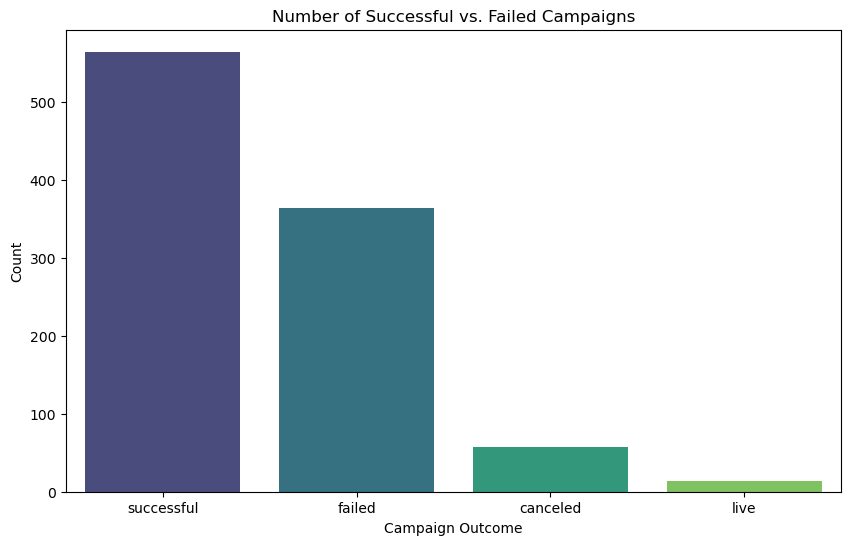

In [9]:
# Create the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=df_outcome, x='outcome', y='count', palette='viridis')
plt.title('Number of Successful vs. Failed Campaigns')
plt.xlabel('Campaign Outcome')
plt.ylabel('Count')

# Save the plot as an image file (e.g., PNG format)
plt.savefig('output/outcome_plot.png')

plt.show()

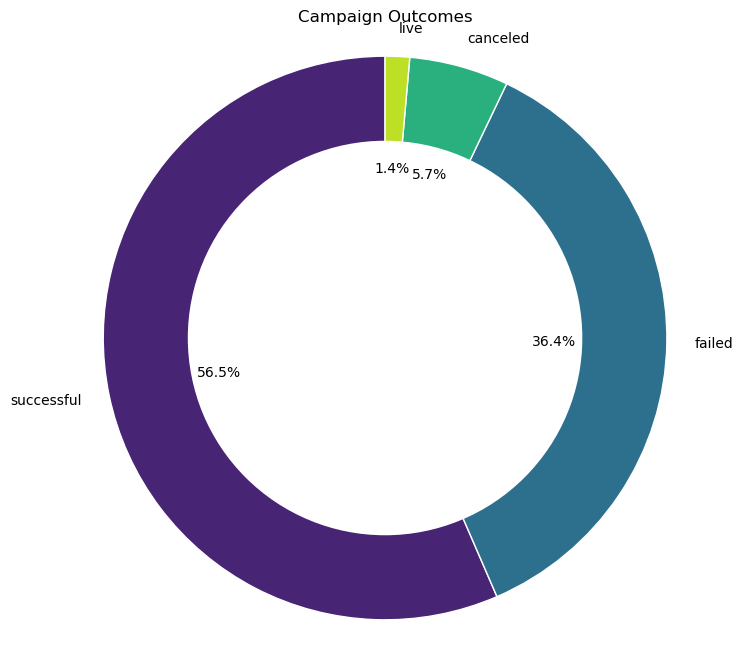

In [10]:
# Plotting the donut chart
# define labels 
labels = df_outcome['outcome'].tolist()
sizes = df_outcome['count'].tolist()
colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(labels)))
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'white'})
# Draw a circle to create a donut chart
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

# Add title
plt.title('Campaign Outcomes')
# Save the plot as an image file (e.g., PNG format)
plt.savefig('output/outcome_donut.png')

# Display the plot
plt.show()

## Number of Campaigns by Country

In [12]:
campaign_df.country.unique()

array(['CA', 'US', 'AU', 'DK', 'GB', 'CH', 'IT'], dtype=object)

In [13]:
# Group by country
country_counts = campaign_df['country'].value_counts().sort_values(ascending=False)
print(country_counts.head())

# Save the grouped data to a CSV file (optional)
country_counts.to_csv('output/country_counts.csv')

country
US    763
GB     48
IT     48
CA     44
AU     43
Name: count, dtype: int64


C:\Users\Isbelis\AppData\Local\Temp\ipykernel_6784\5553417.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis', len(country_counts))


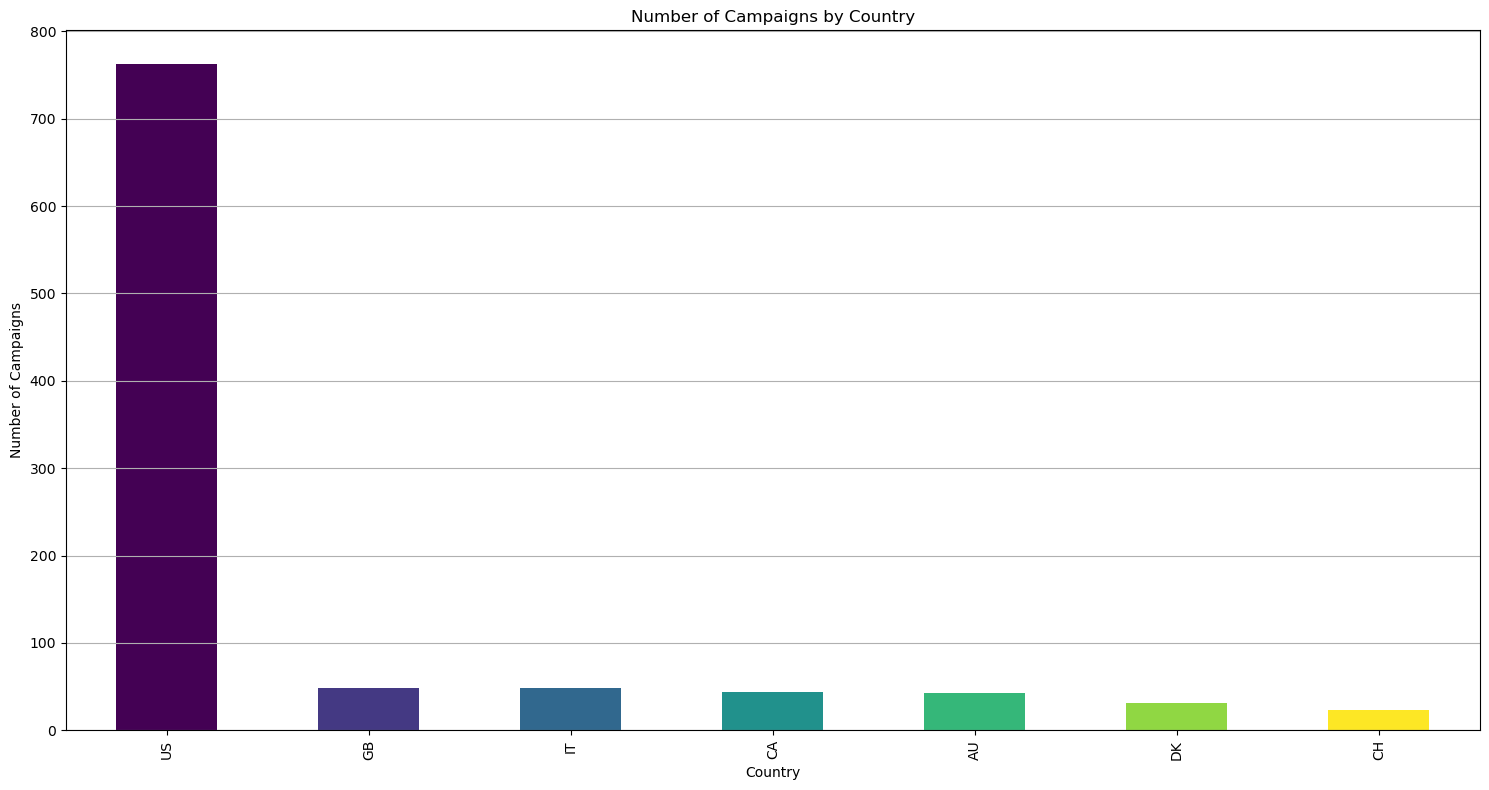

In [14]:
# Plotting the number of campaigns by country using Viridis color palette
plt.figure(figsize=(15, 8))
viridis = plt.cm.get_cmap('viridis', len(country_counts))

country_counts.plot(kind='bar', color=[viridis(i) for i in range(len(country_counts))])
plt.title('Number of Campaigns by Country')
plt.xlabel('Country')
plt.ylabel('Number of Campaigns')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('output/number_of_campaigns_by_country.png')
plt.show()

## Analysis by category

In [16]:
# SQL query to count successful campaigns by category and subcategory
query_category = """
SELECT 
    ca.category_id,
    ca.category,
    COUNT(*) as count
FROM 
    campaign AS c
JOIN 
    category AS ca ON c.category_id = ca.category_id
WHERE 
    c.outcome = 'successful'
GROUP BY 
    ca.category_id
ORDER BY 
    count DESC;
    """


# Execute the query and load the data into a pandas DataFrame
with engine.connect() as connection:
    result = connection.execute(text(query_category))
    category_df = pd.DataFrame(result.fetchall(), columns=result.keys())

# Display the data
category_df.head()

,category_id,category,count
0,cat4,theater,187
1,cat5,film & video,102
2,cat2,music,99
3,cat3,technology,64
4,cat6,publishing,40


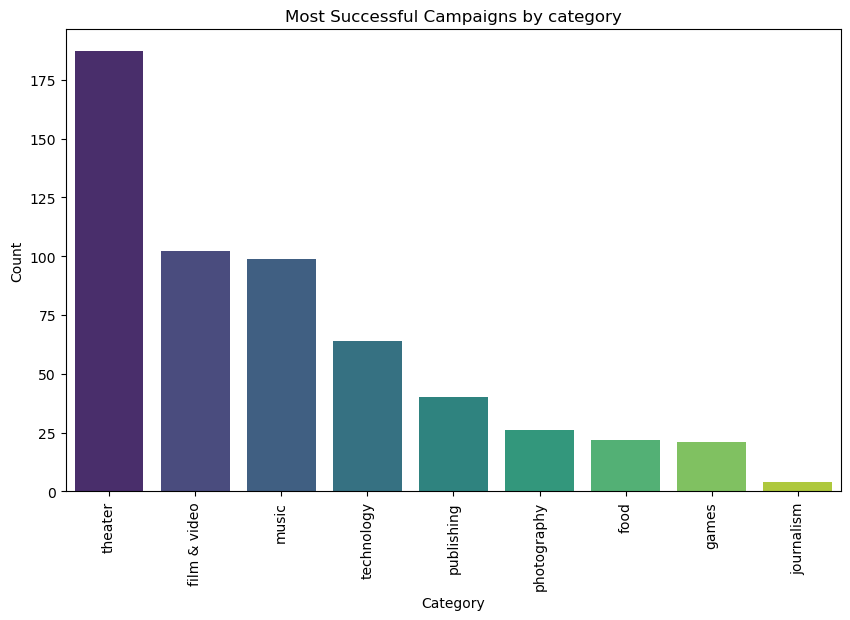

In [17]:
# Ensure the 'output' directory exists
os.makedirs('output', exist_ok=True)

# Create the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=category_df, x='category', y='count', palette='viridis')
plt.title('Most Successful Campaigns by category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=90, fontsize=10)  # Rotate x-axis labels and set font size

# Save the plot as an image file (e.g., PNG format)
plt.savefig('output/category_plot.png')
plt.show()

## Analysis by subcategory

In [19]:
# SQL query to count successful campaigns by category and subcategory
query_subcategory = """
SELECT 
    sub.subcategory_id,
    sub.subcategory,
    COUNT(*) as count
FROM 
    campaign as c
JOIN
    subcategory as sub on c.subcategory_id = sub.subcategory_id
WHERE 
    c.outcome = 'successful'
GROUP BY 
    sub.subcategory_id
ORDER BY 
    count DESC
"""

# Execute the query and load the data into a pandas DataFrame
with engine.connect() as connection:
    result = connection.execute(text(query_subcategory))
    subcategory_df = pd.DataFrame(result.fetchall(), columns=result.keys())

# Display the data
subcategory_df.head(10)

,subcategory_id,subcategory,count
0,subcat4,plays,187
1,subcat2,rock,49
2,subcat3,web,36
3,subcat5,documentary,34
4,subcat9,wearables,28
5,subcat15,photography books,26
6,subcat8,indie rock,23
7,subcat1,food trucks,22
8,subcat7,drama,22
9,subcat11,animation,21


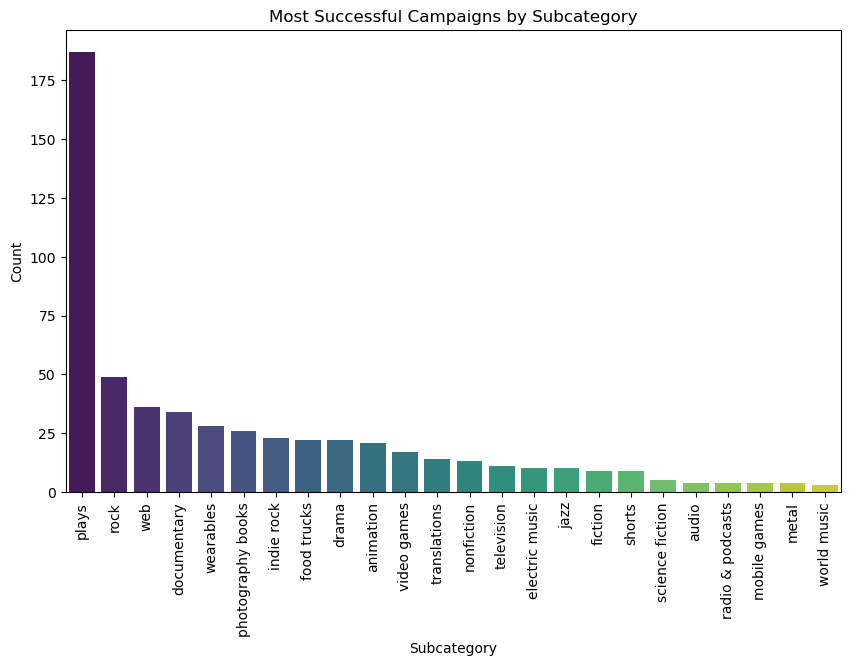

In [20]:
# Ensure the 'output' directory exists
os.makedirs('output', exist_ok=True)

# Create the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=subcategory_df, x='subcategory', y='count', palette='viridis')
plt.title('Most Successful Campaigns by Subcategory')
plt.xlabel('Subcategory')
plt.ylabel('Count')
plt.xticks(rotation=90, fontsize=10)  # Rotate x-axis labels and set font size

# Save the plot as an image file (e.g., PNG format)
plt.savefig('output/subcategory_plot.png')
plt.show()

## Analysis of success campaigns

In [22]:
# merge tables previo to analysis
sql_query = """
SELECT 
    c.cf_id,
    c.company_name,
    c.outcome,
    c.backers_count,
    c.country,
    c.goal,
    c.pledged,
    c.launch_date,
    cat.category,
    sub.subcategory,
    con.First_name,
    con.Last_name,
    con.email
    
FROM 
    campaign c
JOIN 
    category cat ON c.category_id = cat.category_id
JOIN 
    subcategory sub ON c.subcategory_id = sub.subcategory_id
JOIN 
    contacts con ON c.contact_id = con.contact_id;
"""
# Execute the query and load the data into a DataFrame
Join_df = pd.read_sql(text(sql_query), con=engine)
Join_df.head()

# Save the result to a CSV file
Join_df.to_csv('output/joined_data.csv', index=False)

In [23]:
Join_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   cf_id          1000 non-null   int64         
 1   company_name   1000 non-null   object        
 2   outcome        1000 non-null   object        
 3   backers_count  1000 non-null   int64         
 4   country        1000 non-null   object        
 5   goal           1000 non-null   float64       
 6   pledged        1000 non-null   float64       
 7   launch_date    1000 non-null   datetime64[ns]
 8   category       1000 non-null   object        
 9   subcategory    1000 non-null   object        
 10  first_name     1000 non-null   object        
 11  last_name      1000 non-null   object        
 12  email          1000 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(8)
memory usage: 101.7+ KB


In [24]:
# Convert launch_date to datetime
Join_df['launch_date'] = pd.to_datetime(Join_df['launch_date'])
Join_df['year'] = Join_df['launch_date'].dt.year
Join_df['month'] = Join_df['launch_date'].dt.month

In [25]:
# Filter for only 'successful' and 'failed' outcomes
success_df = Join_df[Join_df['outcome'].isin(['successful', 'failed'])]
success_df

,cf_id,company_name,outcome,backers_count,country,goal,pledged,launch_date,category,subcategory,first_name,last_name,email,year,month
0,147,"Baldwin, Riley and Jackson",failed,0,CA,100.0,0.0,2020-02-13 06:00:00,food,food trucks,Cecilia,Velasco,cecilia.velasco@rodrigues.fr,2020,2
1,1621,Odom Inc,successful,158,US,1400.0,14560.0,2021-01-25 06:00:00,music,rock,Mariana,Ellis,mariana.ellis@rossi.org,2021,1
2,1812,"Melton, Robinson and Fritz",successful,1425,AU,108400.0,142523.0,2020-12-17 06:00:00,technology,web,Sofie,Woods,sofie.woods@riviere.com,2020,12
3,2156,"Mcdonald, Gonzalez and Ross",failed,24,US,4200.0,2477.0,2021-10-21 05:00:00,music,rock,Jeanette,Iannotti,jeanette.iannotti@yahoo.com,2021,10
4,1365,Larson-Little,failed,53,US,7600.0,5265.0,2020-12-21 06:00:00,theater,plays,Samuel,Sorgatz,samuel.sorgatz@gmail.com,2020,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,439,Morrow Inc,successful,132,US,3100.0,13223.0,2020-06-14 05:00:00,film & video,drama,Julio,Renner,julio.renner@industrias.net,2020,6
994,1419,"Leach, Rich and Price",failed,842,US,141100.0,74073.0,2021-11-15 06:00:00,publishing,translations,Guadalupe,Munoz,guadalupe.munoz@murray-hamilton.com.au,2021,11
995,2986,Manning-Hamilton,successful,2043,US,97300.0,153216.0,2020-12-29 06:00:00,food,food trucks,Whitney,Noack,whitney.noack@laboratorios.org,2020,12
996,2031,Butler LLC,failed,112,US,6600.0,4814.0,2021-10-15 05:00:00,theater,plays,Gelsomina,Migliaccio,gelsomina.migliaccio@junk.com,2021,10


In [26]:
print(success_df.dtypes)

cf_id                     int64
company_name             object
outcome                  object
backers_count             int64
country                  object
goal                    float64
pledged                 float64
launch_date      datetime64[ns]
category                 object
subcategory              object
first_name               object
last_name                object
email                    object
year                      int32
month                     int32
dtype: object


In [43]:
# Add a column to calculate the success rate
success_df = success_df.assign(success_rate=success_df['pledged'] / success_df['goal'])
success_df.head()

,cf_id,company_name,outcome,backers_count,country,goal,pledged,launch_date,category,subcategory,first_name,last_name,email,year,month,success_rate
0,147,"Baldwin, Riley and Jackson",failed,0,CA,100.0,0.0,2020-02-13 06:00:00,food,food trucks,Cecilia,Velasco,cecilia.velasco@rodrigues.fr,2020,2,0.000000
1,1621,Odom Inc,successful,158,US,1400.0,14560.0,2021-01-25 06:00:00,music,rock,Mariana,Ellis,mariana.ellis@rossi.org,2021,1,10.400000
2,1812,"Melton, Robinson and Fritz",successful,1425,AU,108400.0,142523.0,2020-12-17 06:00:00,technology,web,Sofie,Woods,sofie.woods@riviere.com,2020,12,1.314788
3,2156,"Mcdonald, Gonzalez and Ross",failed,24,US,4200.0,2477.0,2021-10-21 05:00:00,music,rock,Jeanette,Iannotti,jeanette.iannotti@yahoo.com,2021,10,0.589762
4,1365,Larson-Little,failed,53,US,7600.0,5265.0,2020-12-21 06:00:00,theater,plays,Samuel,Sorgatz,samuel.sorgatz@gmail.com,2020,12,0.692763


### Analysis outcome( successful and failed) campaigns by moth and year

In [29]:
# Group by month and year
monthly_outcome = success_df.groupby(['year', 'month', 'outcome']).size().unstack(fill_value=0)
monthly_outcome.head()

outcome     failed  successful
year month                    
2020 1           2           0
     2           5           4
     3           3           8
     4          11          14
     5          16          17

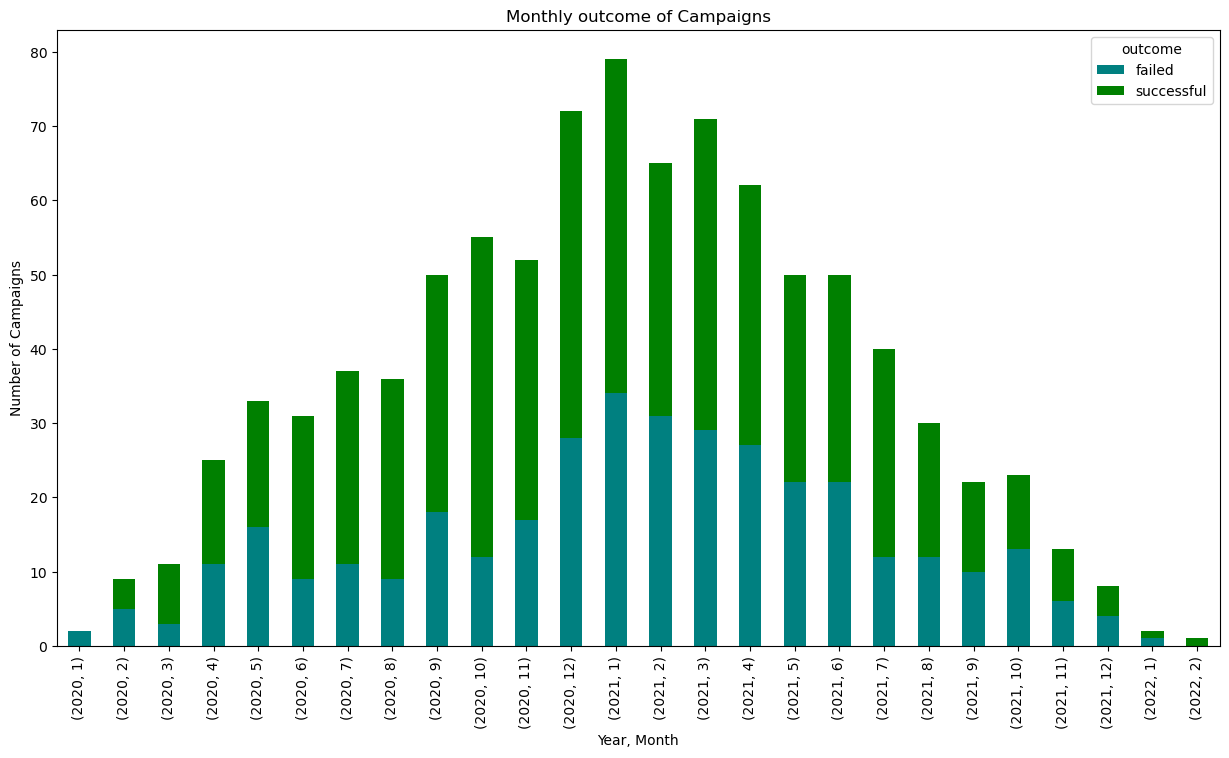

In [30]:
# Plotting the monthly outcome of campaigns
monthly_outcome.plot(kind='bar', stacked=True, figsize=(15, 8), color=('teal','green'))
plt.title('Monthly outcome of Campaigns')
plt.xlabel('Year, Month')
plt.ylabel('Number of Campaigns')
plt.savefig('output/monthly_outcome_of_campaigns.png')
plt.show()

In [31]:
# Group by year
year_outcome = success_df.groupby(['year', 'outcome']).size().unstack(fill_value=0)
year_outcome.head()

outcome,failed,successful
year,,
2020,141,272
2021,222,291
2022,1,2


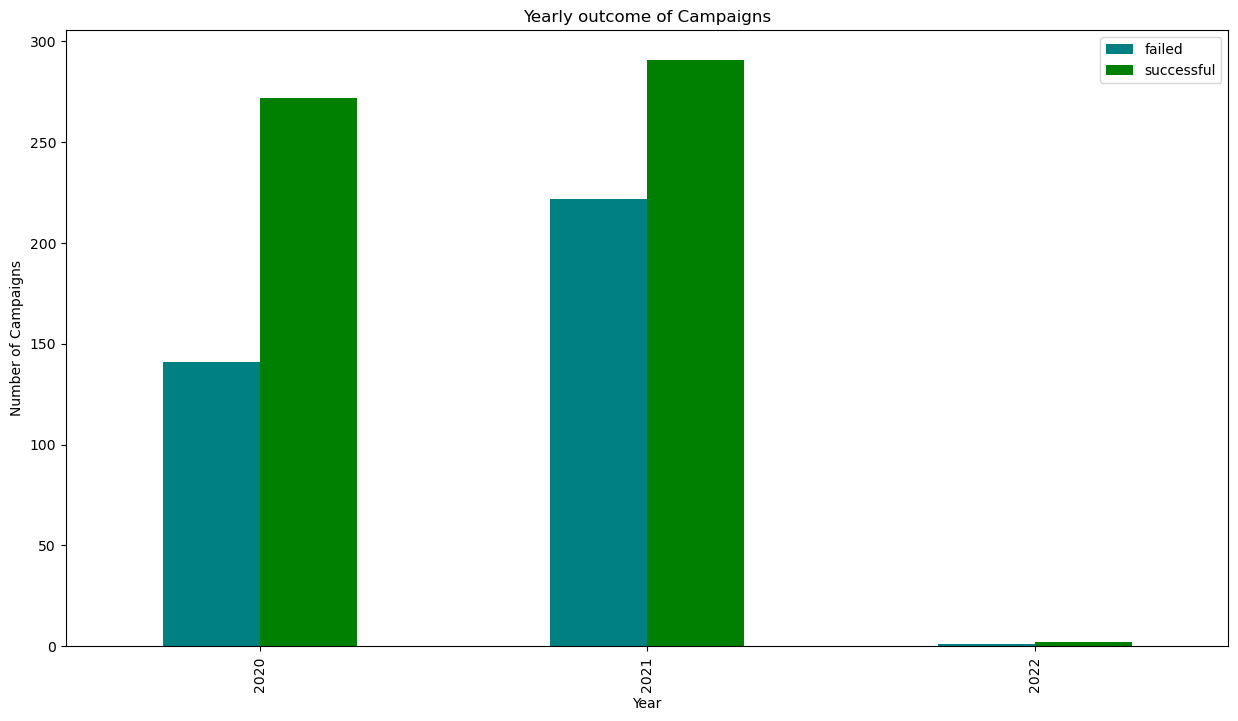

In [32]:
# Plotting the yearly outcome of campaigns
fig, ax = plt.subplots()
year_outcome.plot(kind='bar', ax=ax, figsize=(15, 8), color=('teal','green'))
plt.title('Yearly outcome of Campaigns')
plt.xlabel('Year')
ax.legend(["failed","successful"])
plt.ylabel('Number of Campaigns')
plt.savefig('output/yearly_outcome_of_campaigns.png')
plt.show()

### Analysis Success Rate by Category

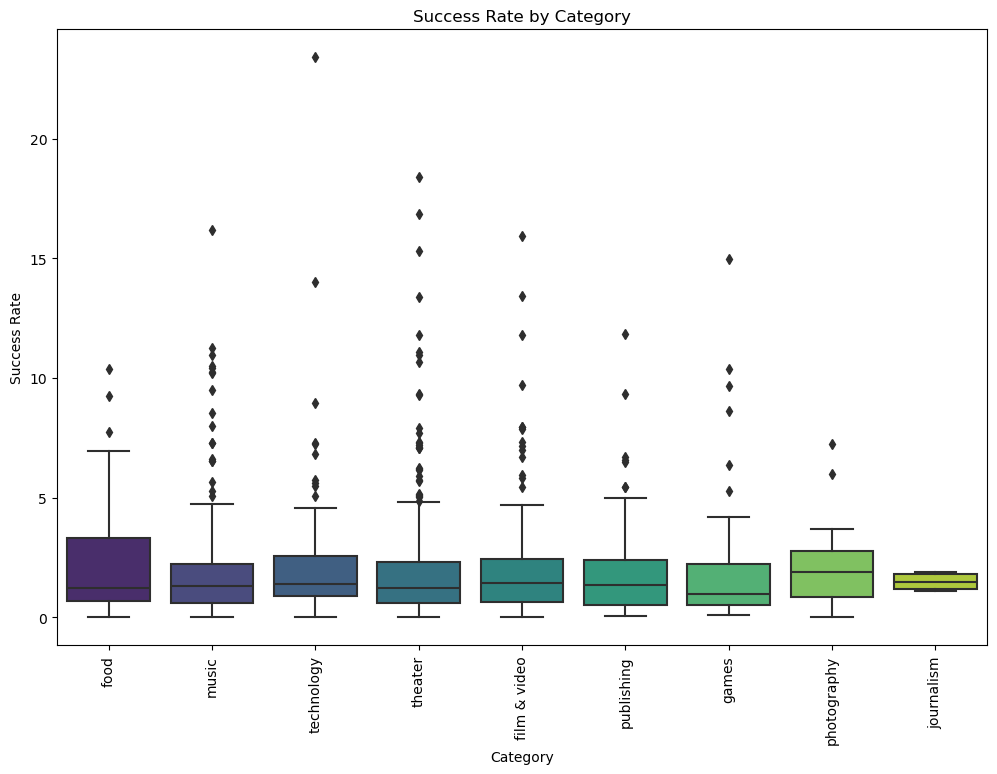

In [34]:
# Boxplot of Success Rate by Category
plt.figure(figsize=(12, 8))
sns.boxplot(x='category', y='success_rate', data=success_df,  palette='viridis')
plt.xticks(rotation=90)
plt.title('Success Rate by Category')
plt.xlabel('Category')
plt.ylabel('Success Rate')
plt.savefig('output/success_rate_by_category.png')
plt.show()

### Analysis Goal by Category

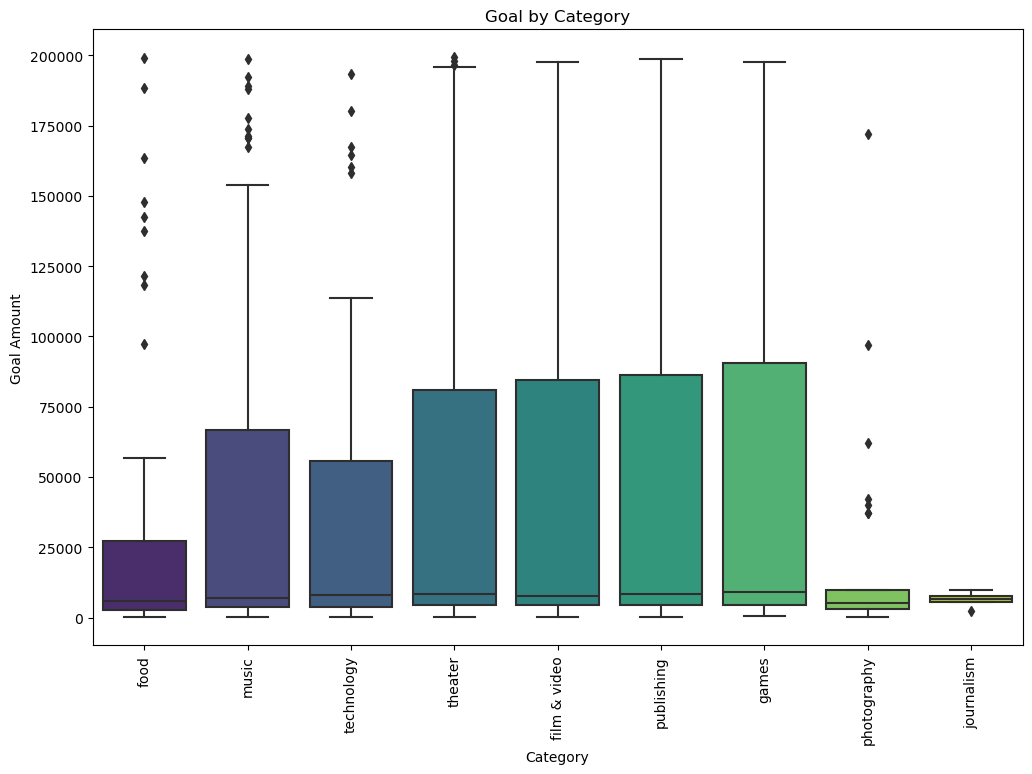

In [36]:
# Boxplot of goals Amounts by Category (include only success, failed)
plt.figure(figsize=(12, 8))
sns.boxplot(x='category', y='goal', data=success_df,  palette='viridis')
plt.xticks(rotation=90)
plt.title('Goal by Category')
plt.xlabel('Category')
plt.ylabel('Goal Amount')
plt.savefig('output/goal_amount_by_category.png')
plt.show()

### Analysis Pledged Amounts by Category

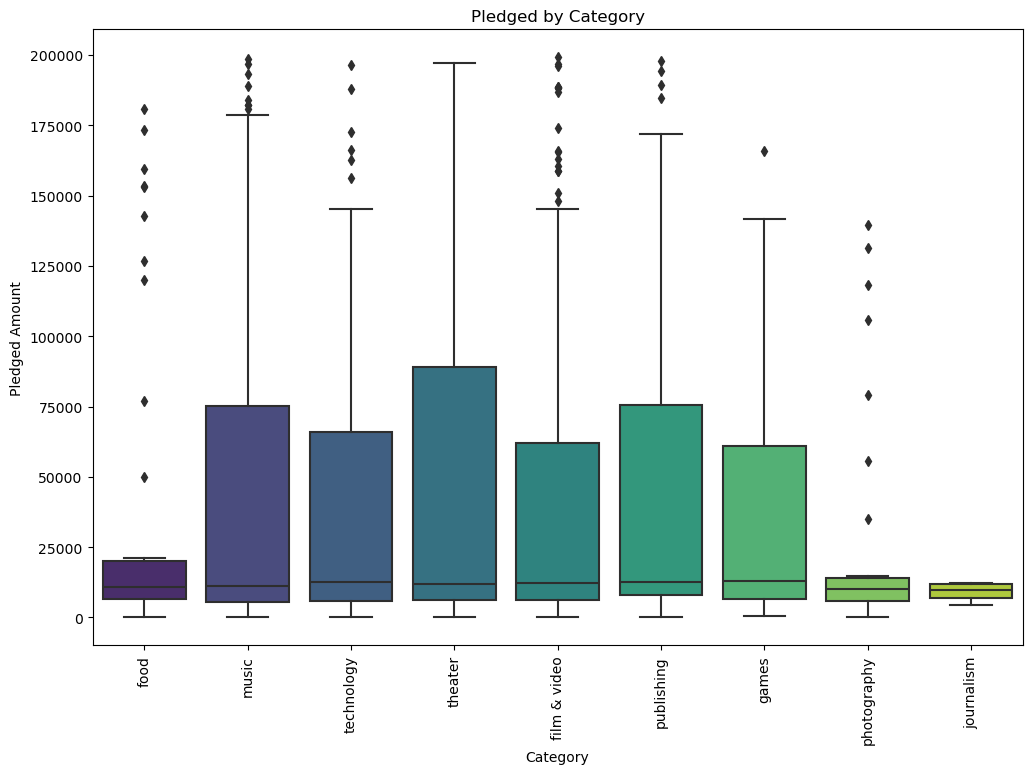

In [38]:
# Boxplot of Pledged Amounts by Category
plt.figure(figsize=(12, 8))
sns.boxplot(x='category', y='pledged', data=success_df,  palette='viridis')
plt.xticks(rotation=90)
plt.title('Pledged by Category')
plt.xlabel('Category')
plt.ylabel('Pledged Amount')
plt.savefig('output/pledged_amount_by_category.png')
plt.show()

# How do the goals and number of backers compare between successful and failed campaigns?

In [40]:
# Query 3 - How do the goals and number of backers compare between successful and failed campaigns?

# Select all rows in goal and backers_count that were failed in outcome and create a df
query = """
SELECT goal, backers_count
FROM campaign
WHERE outcome = 'failed';
"""
failed_df = pd.read_sql(text(query), con=engine)
failed_df

,goal,backers_count
0,100.0,0
1,4200.0,24
2,7600.0,53
3,5200.0,18
4,6200.0,44
...,...,...
359,9400.0,64
360,7800.0,64
361,141100.0,842
362,6600.0,112


In [41]:
# Select all rows in goal and backers_count that were successful in outcome and create a df
query = """
SELECT goal, backers_count
FROM campaign
WHERE outcome = 'successful';
"""
successful_df = pd.read_sql(text(query), con=engine)
successful_df

,goal,backers_count
0,1400.0,158
1,108400.0,1425
2,7600.0,174
3,4500.0,227
4,5200.0,220
...,...,...
560,6200.0,480
561,2400.0,226
562,9800.0,241
563,3100.0,132


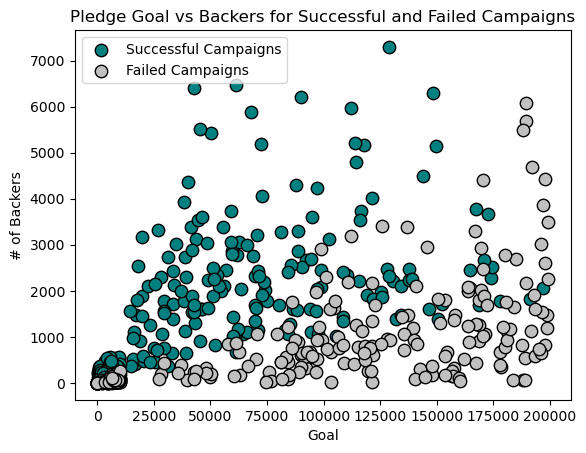

In [42]:
# Combine the two scatterplots
# Create first scatter plot within the 'ax' element
ax = successful_df.plot.scatter(x='goal', y='backers_count', color='teal', edgecolor='black', s=80, label='Successful Campaigns')

# Create second scatter plot, using 'ax' element
failed_df.plot.scatter(x='goal', y='backers_count', color='silver', edgecolor='black', s=80, label='Failed Campaigns', ax=ax)

# Title and labels
plt.xlabel('Goal')
plt.ylabel('# of Backers')
plt.title('Pledge Goal vs Backers for Successful and Failed Campaigns')

# Show
plt.show()